In [1]:
import collections
import gc
import os
import multiprocessing
import sys
from datetime import datetime

import shap
import pandas as pd
import numpy as np
import lightgbm as lgb
import sklearn.metrics
import skopt
import ml_metrics
import tqdm
from gensim.models import Word2Vec

In [2]:
time_started = datetime.now()

In [3]:
# Reproducibility parameters
SEED = 281989

# Explainability parameters
EXPLAIN_FROM_SAMPLES = 1000

# Word2Vec parameters
WORD2VEC_EMBEDDING_SIZE = 32
WORD2VEC_EPOCHS = 10

# Evaluation parameters
CROSS_VALIDATION_K = 5
MAP_K = 10

In [4]:
# Data description: https://www.kaggle.com/c/kkbox-music-recommendation-challenge/data
data_dir = 'data'

In [5]:
train_columns = {
  'msno': 'category',
  'song_id': 'category',
  'source_system_tab': 'category',
  'source_screen_name': 'category',
  'source_type': 'category',
  'target': np.uint8,
}
train_df_raw = pd.read_csv(os.path.join(data_dir, 'train.csv'), dtype=train_columns)
print(train_df_raw.dtypes)
train_df_raw.head()

msno                  category
song_id               category
source_system_tab     category
source_screen_name    category
source_type           category
target                   uint8
dtype: object


,msno,song_id,source_system_tab,source_screen_name,source_type,target
0,FGtllVqz18RPiwJj/edr2gV78zirAiY/9SmYvia+kCg=,BBzumQNXUHKdEBOB7mAJuzok+IJA1c2Ryg/yzTF6tik=,explore,Explore,online-playlist,1
1,Xumu+NIjS6QYVxDS4/t3SawvJ7viT9hPKXmf0RtLNx8=,bhp/MpSNoqoxOIB+/l8WPqu6jldth4DIpCm3ayXnJqM=,my library,Local playlist more,local-playlist,1
2,Xumu+NIjS6QYVxDS4/t3SawvJ7viT9hPKXmf0RtLNx8=,JNWfrrC7zNN7BdMpsISKa4Mw+xVJYNnxXh3/Epw7QgY=,my library,Local playlist more,local-playlist,1
3,Xumu+NIjS6QYVxDS4/t3SawvJ7viT9hPKXmf0RtLNx8=,2A87tzfnJTSWqD7gIZHisolhe4DMdzkbd6LzO1KHjNs=,my library,Local playlist more,local-playlist,1
4,FGtllVqz18RPiwJj/edr2gV78zirAiY/9SmYvia+kCg=,3qm6XTZ6MOCU11x8FIVbAGH5l5uMkT3/ZalWG1oo2Gc=,explore,Explore,online-playlist,1


In [6]:
songs_columns = {
  'song_id': 'category',
  'song_length': np.int,
  'genre_ids': 'category',
  'artist_name': 'category',
  'composer': 'category',
  'lyricist': 'category',
  'language': 'category',
}
songs_df_raw = pd.read_csv(os.path.join(data_dir, 'songs.csv'), dtype=songs_columns)
print(songs_df_raw.dtypes)
songs_df_raw.head()

song_id        category
song_length       int64
genre_ids      category
artist_name    category
composer       category
lyricist       category
language       category
dtype: object


,song_id,song_length,genre_ids,artist_name,composer,lyricist,language
0,CXoTN1eb7AI+DntdU1vbcwGRV4SCIDxZu+YD8JP8r4E=,247640,465,張信哲 (Jeff Chang),董貞,何啟弘,3.0
1,o0kFgae9QtnYgRkVPqLJwa05zIhRlUjfF7O1tDw0ZDU=,197328,444,BLACKPINK,TEDDY| FUTURE BOUNCE| Bekuh BOOM,TEDDY,31.0
2,DwVvVurfpuz+XPuFvucclVQEyPqcpUkHR0ne1RQzPs0=,231781,465,SUPER JUNIOR,NaN,NaN,31.0
3,dKMBWoZyScdxSkihKG+Vf47nc18N9q4m58+b4e7dSSE=,273554,465,S.H.E,湯小康,徐世珍,3.0
4,W3bqWd3T+VeHFzHAUfARgW9AvVRaF4N5Yzm4Mr6Eo/o=,140329,726,貴族精選,Traditional,Traditional,52.0


In [7]:
members_columns = {
  'msno': 'category',
  'city': 'category',
  'bd': np.int,
  'gender': 'category',
  'registered_via': 'category',
  'registration_init_time': str,
  'expiration_date': str,
}
members_df_raw = pd.read_csv(os.path.join(data_dir, 'members.csv'), dtype=members_columns)
print(members_df_raw.dtypes)
members_df_raw.head()

msno                      category
city                      category
bd                           int64
gender                    category
registered_via            category
registration_init_time      object
expiration_date             object
dtype: object


,msno,city,bd,gender,registered_via,registration_init_time,expiration_date
0,XQxgAYj3klVKjR3oxPPXYYFp4soD4TuBghkhMTD4oTw=,1,0,NaN,7,20110820,20170920
1,UizsfmJb9mV54qE9hCYyU07Va97c0lCRLEQX3ae+ztM=,1,0,NaN,7,20150628,20170622
2,D8nEhsIOBSoE6VthTaqDX8U6lqjJ7dLdr72mOyLya2A=,1,0,NaN,4,20160411,20170712
3,mCuD+tZ1hERA/o5GPqk38e041J8ZsBaLcu7nGoIIvhI=,1,0,NaN,9,20150906,20150907
4,q4HRBfVSssAFS9iRfxWrohxuk9kCYMKjHOEagUMV6rQ=,1,0,NaN,4,20170126,20170613


In [8]:
song_extra_info_columns = {
  'song_id': 'category',
  'name': 'category',
  'isrc': 'category',
}
song_extra_info_df_raw = pd.read_csv(os.path.join(data_dir, 'song_extra_info.csv'), dtype=song_extra_info_columns)
print(song_extra_info_df_raw.dtypes)
song_extra_info_df_raw.head()

song_id    category
name       category
isrc       category
dtype: object


,song_id,name,isrc
0,LP7pLJoJFBvyuUwvu+oLzjT+bI+UeBPURCecJsX1jjs=,我們,TWUM71200043
1,ClazTFnk6r0Bnuie44bocdNMM3rdlrq0bCGAsGUWcHE=,Let Me Love You,QMZSY1600015
2,u2ja/bZE3zhCGxvbbOB3zOoUjx27u40cf5g09UXMoKQ=,原諒我,TWA530887303
3,92Fqsy0+p6+RHe2EoLKjHahORHR1Kq1TBJoClW9v+Ts=,Classic,USSM11301446
4,0QFmz/+rJy1Q56C1DuYqT9hKKqi5TUqx0sN0IwvoHrw=,愛投羅網,TWA471306001


In [9]:
train_df = train_df_raw.merge(songs_df_raw, on='song_id', how='left')

In [10]:
def parse_yearmonthday(date):
  parts = date[0:4], date[4:6], date[6:8]
  return list(map(int, parts))

In [11]:
members_df = members_df_raw.copy()

In [12]:
reg_init_label = 'registration_init_time'
members_df['registration_year'] = members_df[reg_init_label].apply(lambda date: parse_yearmonthday(date)[0])
members_df['registration_month'] = members_df[reg_init_label].apply(lambda date: parse_yearmonthday(date)[1])
members_df['registration_day'] = members_df[reg_init_label].apply(lambda date: parse_yearmonthday(date)[2])
members_df = members_df.drop([reg_init_label], axis=1)

In [13]:
exp_label = 'expiration_date'
members_df['expiration_year'] = members_df[exp_label].apply(lambda date: parse_yearmonthday(date)[0])
members_df['expiration_month'] = members_df[exp_label].apply(lambda date: parse_yearmonthday(date)[1])
members_df['expiration_day'] = members_df[exp_label].apply(lambda date: parse_yearmonthday(date)[2])
members_df = members_df.drop([exp_label], axis=1)

In [14]:
train_df = train_df.merge(members_df, on='msno', how='left')

In [15]:
def isrc_to_year(isrc):
  if type(isrc) == str:
    if int(isrc[5:7]) > 17:
      return 1900 + int(isrc[5:7])
    else:
      return 2000 + int(isrc[5:7])
  else:
    return np.nan

song_extra_info_df = song_extra_info_df_raw.copy()
song_extra_info_df['song_year'] = song_extra_info_df['isrc'].apply(isrc_to_year).astype(np.float64)
song_extra_info_df.drop(['isrc', 'name'], axis=1, inplace=True)

In [16]:
train_df = train_df.merge(song_extra_info_df, on='song_id', how='left')

In [17]:
for col in train_df.columns:
  if train_df[col].dtype == object:
    train_df[col] = train_df[col].astype('category')

Some feature engineering to abstract from high dimensional categorical data.

In [18]:
user_listened_to_genres = []
dict_user_listened_to_genres = collections.defaultdict(int)

for msno, genre_ids in zip(train_df['msno'], train_df['genre_ids']):
  if pd.isna(genre_ids):
    row_value = np.nan
  else:
    row_sum = 0.0
    row_count = 0
    for genre in genre_ids.split('|'):
      key = (msno, genre)
      value = dict_user_listened_to_genres[key]
      dict_user_listened_to_genres[key] = value + 1
      row_sum += value
      row_count += 1
    row_value = row_sum / row_count
  user_listened_to_genres.append(row_value)
  
train_df['user_listened_to_genres'] = np.array(user_listened_to_genres, dtype=np.float64)

del user_listened_to_genres, dict_user_listened_to_genres
gc.collect()

0

In [19]:
user_listened_to_artist = []
dict_user_listened_to_artist = collections.defaultdict(int)

for msno, artist_name in zip(train_df['msno'], train_df['artist_name']):
  if pd.isna(artist_name):
    row_value = np.nan
  else:
    key = (msno, artist_name)
    row_value = dict_user_listened_to_artist[key]
    dict_user_listened_to_artist[key] = row_value + 1
  user_listened_to_artist.append(row_value)
  
train_df['user_listened_to_artist'] = np.array(user_listened_to_artist, dtype=np.float64)

del user_listened_to_artist, dict_user_listened_to_artist
gc.collect()

0

Here is how our all data columns look like (the subset of which will be used as features).

In [20]:
train_df.head()

,msno,song_id,source_system_tab,source_screen_name,source_type,target,song_length,genre_ids,artist_name,composer,...,registered_via,registration_year,registration_month,registration_day,expiration_year,expiration_month,expiration_day,song_year,user_listened_to_genres,user_listened_to_artist
0,FGtllVqz18RPiwJj/edr2gV78zirAiY/9SmYvia+kCg=,BBzumQNXUHKdEBOB7mAJuzok+IJA1c2Ryg/yzTF6tik=,explore,Explore,online-playlist,1,206471.0,359,Bastille,Dan Smith| Mark Crew,...,7,2012,1,2,2017,10,5,2016.0,0.0,0.0
1,Xumu+NIjS6QYVxDS4/t3SawvJ7viT9hPKXmf0RtLNx8=,bhp/MpSNoqoxOIB+/l8WPqu6jldth4DIpCm3ayXnJqM=,my library,Local playlist more,local-playlist,1,284584.0,1259,Various Artists,NaN,...,9,2011,5,25,2017,9,11,1999.0,0.0,0.0
2,Xumu+NIjS6QYVxDS4/t3SawvJ7viT9hPKXmf0RtLNx8=,JNWfrrC7zNN7BdMpsISKa4Mw+xVJYNnxXh3/Epw7QgY=,my library,Local playlist more,local-playlist,1,225396.0,1259,Nas,N. Jones、W. Adams、J. Lordan、D. Ingle,...,9,2011,5,25,2017,9,11,2006.0,1.0,0.0
3,Xumu+NIjS6QYVxDS4/t3SawvJ7viT9hPKXmf0RtLNx8=,2A87tzfnJTSWqD7gIZHisolhe4DMdzkbd6LzO1KHjNs=,my library,Local playlist more,local-playlist,1,255512.0,1019,Soundway,Kwadwo Donkoh,...,9,2011,5,25,2017,9,11,2010.0,0.0,0.0
4,FGtllVqz18RPiwJj/edr2gV78zirAiY/9SmYvia+kCg=,3qm6XTZ6MOCU11x8FIVbAGH5l5uMkT3/ZalWG1oo2Gc=,explore,Explore,online-playlist,1,187802.0,1011,Brett Young,Brett Young| Kelly Archer| Justin Ebach,...,7,2012,1,2,2017,10,5,2016.0,0.0,0.0


In [21]:
train_df.dtypes

msno                       category
song_id                    category
source_system_tab          category
source_screen_name         category
source_type                category
target                        uint8
song_length                 float64
genre_ids                  category
artist_name                category
composer                   category
lyricist                   category
language                   category
city                       category
bd                            int64
gender                     category
registered_via             category
registration_year             int64
registration_month            int64
registration_day              int64
expiration_year               int64
expiration_month              int64
expiration_day                int64
song_year                   float64
user_listened_to_genres     float64
user_listened_to_artist     float64
dtype: object

# GBDT

The subset of the features we use for GBDT:
- we drop all identifying columns (msno, song_id);
- substitute unstructured (genre_ids) field with more general (user_listened_to_genres);
- remove (artist_name, composer, lyricist) and put instead (user_listened_to_artist) which characterizes the relationship between the user and the artist.

In [22]:
feature_columns = [
  'source_system_tab',
  'source_screen_name',
  'source_type',
  'song_length',
  'user_listened_to_genres',
  'user_listened_to_artist',
  'language',
  'city',
  'bd',
  'gender',
  'registered_via',
  'registration_year',
  'registration_month',
  'registration_day',
  'expiration_year',
  'expiration_month',
  'expiration_day',
  'song_year'
]

In [23]:
assert 'target' not in feature_columns
assert all(feature_column in train_df.columns for feature_column in feature_columns)

In [24]:
print('len(feature_columns):', len(feature_columns))
print('len(train_df.columns):', len(train_df.columns))

len(feature_columns): 18
len(train_df.columns): 25


In [25]:
def train_lightgbm(train_df, feature_columns, update_params=None):
  global latest_model
  D_train = lgb.Dataset(train_df[feature_columns], train_df['target'])
  watchlist = [D_train]
  
  # LightGBM default parameters
  params = {
    'num_boost_round': 100,
    'early_stopping_rounds': 10,
    'learning_rate': 0.2,
    'max_depth': 8,
    'objective': 'binary',
    'metric': 'auc',
    'num_leaves': 256,
    'verbosity': 0,
    'boosting': 'gbdt',
  }
  if update_params:
    params.update(update_params)
  print(f'Training the model with params {params}')
  num_boost_round = params['num_boost_round']
  early_stopping_rounds = params['early_stopping_rounds']
  del params['num_boost_round']
  del params['early_stopping_rounds']

  model = lgb.train(
    params=params,
    train_set=D_train,
    num_boost_round=num_boost_round,
    early_stopping_rounds=early_stopping_rounds,
    valid_sets=watchlist,
    verbose_eval=0)
  return model

In [26]:
def lightgbm_ranking_fn(model, eval_df):
  return model.predict(eval_df[model.feature_name()])

In [27]:
ModelEvaluation = collections.namedtuple('ModelEvaluation', ['mapk'])

def evaluate_model_ranking_fn(ranking_fn, val_df) -> ModelEvaluation:
  print('Running the model inference')
  ranking_values = ranking_fn(val_df)
  user_to_song_id_ranks = collections.defaultdict(list)
  user_to_relevant_song_ids = collections.defaultdict(list)
  print('Aggregating the results')
  for user_id, song_id, target, rank in tqdm.tqdm(
      zip(val_df['msno'], val_df['song_id'], val_df['target'], ranking_values), file=sys.stdout):
    user_to_song_id_ranks[user_id].append((song_id, rank))
    if target == 1.0:
      user_to_relevant_song_ids[user_id].append(song_id)
    
  print('Evaluating by user')
  apks = []
  for user_id in tqdm.tqdm(user_to_song_id_ranks.keys(), file=sys.stdout):
    song_id_ranks = user_to_song_id_ranks[user_id]
    song_id_ranks.sort(key=lambda song_id_rank: song_id_rank[1], reverse=True)
    ranked_song_ids = list(map(lambda song_id_rank: song_id_rank[0], song_id_ranks))
    relevant_song_ids = user_to_relevant_song_ids[user_id]
    apk = ml_metrics.apk(relevant_song_ids, ranked_song_ids, MAP_K)
    apks.append(apk)
  evaluation = ModelEvaluation(mapk=np.mean(apks))
  print(evaluation)
  return evaluation

In [28]:
def k_fold_cross_validation(full_df, k, train_model_fn, preprocess_val_fn, build_ranking_fn):
  indexes = np.array(full_df.index)
  np.random.seed(SEED)
  np.random.shuffle(indexes)
  full_df_splits = np.array_split(indexes, k)
  
  evaluations = []
  for split_index, val_indexes in enumerate(full_df_splits):
    print(f'Taking split number {split_index} as the validation set')
    train_indexes = np.setdiff1d(indexes, val_indexes)

    train_df = full_df.iloc[train_indexes]
    model = train_model_fn(train_df)
    
    val_df = full_df.iloc[val_indexes]
    if preprocess_val_fn:
      val_df = preprocess_val_fn(model, val_df)
    evaluation = evaluate_model_ranking_fn(build_ranking_fn(model), val_df)
    evaluations.append(evaluation)
  return evaluations

Tuning the lightgbm parameters (using Gaussian process as the surrogate function) to maximize evaluation metric (MAP@10 on K-fold cross validation).

In [29]:
search_space = [
  skopt.space.Integer(10, 100, name='num_boost_round'),
  skopt.space.Real(0.01, 0.5, name='learning_rate', prior='log-uniform'),
  skopt.space.Integer(1, 16, name='max_depth'),
  skopt.space.Integer(16, 256, name='num_leaves'),
]

def tune_params_for_k_fold(k_fold_cross_validation_fn):
  @skopt.utils.use_named_args(search_space)
  def objective(**params):
    evaluations = k_fold_cross_validation_fn(params)
    mapks = list(map(lambda evaluation: evaluation.mapk, evaluations))
    return -np.mean(mapks)

  n_calls = 20
  n_initial_points = min(n_calls, 2 * len(search_space))
  results = skopt.gp_minimize(objective, search_space, n_calls=n_calls, n_initial_points=n_initial_points)
  return results

In [30]:
results = tune_params_for_k_fold(
  lambda params:
    k_fold_cross_validation(
      train_df,
      k=CROSS_VALIDATION_K,
      train_model_fn=lambda train_df: train_lightgbm(train_df, feature_columns, params),
      preprocess_val_fn=None,
      build_ranking_fn=lambda model: lambda eval_df: lightgbm_ranking_fn(model, eval_df)))

Taking split number 0 as the validation set
Training the model with params {'num_boost_round': 84, 'early_stopping_rounds': 10, 'learning_rate': 0.13011695149641642, 'max_depth': 10, 'objective': 'binary', 'metric': 'auc', 'num_leaves': 46, 'verbosity': 0, 'boosting': 'gbdt'}
Running the model inference
Aggregating the results
1475484it [00:01, 1276418.79it/s]
Evaluating by user
100%|██████████| 28614/28614 [00:00<00:00, 38910.45it/s]
ModelEvaluation(mapk=0.6657448229408904)
Taking split number 1 as the validation set
Training the model with params {'num_boost_round': 84, 'early_stopping_rounds': 10, 'learning_rate': 0.13011695149641642, 'max_depth': 10, 'objective': 'binary', 'metric': 'auc', 'num_leaves': 46, 'verbosity': 0, 'boosting': 'gbdt'}
Running the model inference
Aggregating the results
1475484it [00:01, 1076505.44it/s]
Evaluating by user
100%|██████████| 28608/28608 [00:00<00:00, 37833.27it/s]
ModelEvaluation(mapk=0.6648534468968345)
Taking split number 2 as the validation 

Training the model with params {'num_boost_round': 17, 'early_stopping_rounds': 10, 'learning_rate': 0.3265871276266289, 'max_depth': 14, 'objective': 'binary', 'metric': 'auc', 'num_leaves': 216, 'verbosity': 0, 'boosting': 'gbdt'}
Running the model inference
Aggregating the results
1475484it [00:01, 1024139.54it/s]
Evaluating by user
100%|██████████| 28633/28633 [00:00<00:00, 37979.73it/s]
ModelEvaluation(mapk=0.6694180866071358)
Taking split number 3 as the validation set
Training the model with params {'num_boost_round': 17, 'early_stopping_rounds': 10, 'learning_rate': 0.3265871276266289, 'max_depth': 14, 'objective': 'binary', 'metric': 'auc', 'num_leaves': 216, 'verbosity': 0, 'boosting': 'gbdt'}
Running the model inference
Aggregating the results
1475483it [00:01, 960758.83it/s] 
Evaluating by user
100%|██████████| 28629/28629 [00:00<00:00, 38197.37it/s]
ModelEvaluation(mapk=0.6678273383959363)
Taking split number 4 as the validation set
Training the model with params {'num_boo

Running the model inference
Aggregating the results
1475483it [00:01, 1038135.60it/s]
Evaluating by user
100%|██████████| 28643/28643 [00:00<00:00, 37979.40it/s]
ModelEvaluation(mapk=0.6720613468310384)
Taking split number 0 as the validation set
Training the model with params {'num_boost_round': 17, 'early_stopping_rounds': 10, 'learning_rate': 0.3265871276266289, 'max_depth': 14, 'objective': 'binary', 'metric': 'auc', 'num_leaves': 216, 'verbosity': 0, 'boosting': 'gbdt'}
Running the model inference
Aggregating the results
1475484it [00:01, 1035056.11it/s]
Evaluating by user
100%|██████████| 28614/28614 [00:00<00:00, 37757.46it/s]
ModelEvaluation(mapk=0.6688327793593717)
Taking split number 1 as the validation set
Training the model with params {'num_boost_round': 17, 'early_stopping_rounds': 10, 'learning_rate': 0.3265871276266289, 'max_depth': 14, 'objective': 'binary', 'metric': 'auc', 'num_leaves': 216, 'verbosity': 0, 'boosting': 'gbdt'}
Running the model inference
Aggregating 

Aggregating the results
1475484it [00:01, 1020442.30it/s]
Evaluating by user
100%|██████████| 28608/28608 [00:00<00:00, 37644.07it/s]
ModelEvaluation(mapk=0.665838390770748)
Taking split number 2 as the validation set
Training the model with params {'num_boost_round': 10, 'early_stopping_rounds': 10, 'learning_rate': 0.49999999999999994, 'max_depth': 15, 'objective': 'binary', 'metric': 'auc', 'num_leaves': 256, 'verbosity': 0, 'boosting': 'gbdt'}
Running the model inference
Aggregating the results
1475484it [00:01, 992081.06it/s]
Evaluating by user
100%|██████████| 28633/28633 [00:00<00:00, 37550.73it/s]
ModelEvaluation(mapk=0.6695737950039534)
Taking split number 3 as the validation set
Training the model with params {'num_boost_round': 10, 'early_stopping_rounds': 10, 'learning_rate': 0.49999999999999994, 'max_depth': 15, 'objective': 'binary', 'metric': 'auc', 'num_leaves': 256, 'verbosity': 0, 'boosting': 'gbdt'}
Running the model inference
Aggregating the results
1475483it [00:01

1475484it [00:01, 1308705.14it/s]
Evaluating by user
100%|██████████| 28614/28614 [00:00<00:00, 37766.97it/s]
ModelEvaluation(mapk=0.6713240265776039)
Taking split number 1 as the validation set
Training the model with params {'num_boost_round': 92, 'early_stopping_rounds': 10, 'learning_rate': 0.05232004099348021, 'max_depth': 13, 'objective': 'binary', 'metric': 'auc', 'num_leaves': 256, 'verbosity': 0, 'boosting': 'gbdt'}
Running the model inference
Aggregating the results
1475484it [00:01, 1033611.59it/s]
Evaluating by user
100%|██████████| 28608/28608 [00:00<00:00, 37590.07it/s]
ModelEvaluation(mapk=0.67301337642095)
Taking split number 2 as the validation set
Training the model with params {'num_boost_round': 92, 'early_stopping_rounds': 10, 'learning_rate': 0.05232004099348021, 'max_depth': 13, 'objective': 'binary', 'metric': 'auc', 'num_leaves': 256, 'verbosity': 0, 'boosting': 'gbdt'}
Running the model inference
Aggregating the results
1475484it [00:01, 1021915.02it/s]
Evalua

In [31]:
print(f'The final score is: {-results.fun}') 
params = {search_dim.name: param for search_dim, param in zip(search_space, results.x)}
params

The final score is: 0.675146227265702


{'num_boost_round': 100,
 'learning_rate': 0.05418497855695084,
 'max_depth': 16,
 'num_leaves': 256}

Now let's retrain the model on the whole dataset with the best parameters (from K-fold validation) for interpretation.

In [32]:
model = train_lightgbm(train_df, feature_columns, params)
evaluation = evaluate_model_ranking_fn(
  lambda eval_df: lightgbm_ranking_fn(model, eval_df),
  train_df)

Training the model with params {'num_boost_round': 100, 'early_stopping_rounds': 10, 'learning_rate': 0.05418497855695084, 'max_depth': 16, 'objective': 'binary', 'metric': 'auc', 'num_leaves': 256, 'verbosity': 0, 'boosting': 'gbdt'}
Running the model inference
Aggregating the results
7377418it [00:04, 1788969.46it/s]
Evaluating by user
100%|██████████| 30755/30755 [00:03<00:00, 10251.24it/s]
ModelEvaluation(mapk=0.6471483104110096)


Let's look at the SHAP values for the model features.

In [33]:
np.random.seed(SEED)
explain_indexes = np.random.choice(train_df.index, EXPLAIN_FROM_SAMPLES, replace=False)
explain_df = train_df.iloc[explain_indexes][feature_columns]

In [34]:
explainer = shap.TreeExplainer(model, feature_perturbation='tree_path_dependent')
shap_values = explainer.shap_values(explain_df)

LightGBM binary classifier with TreeExplainer shap values output has changed to a list of ndarray


SHAP values' magnitudes.

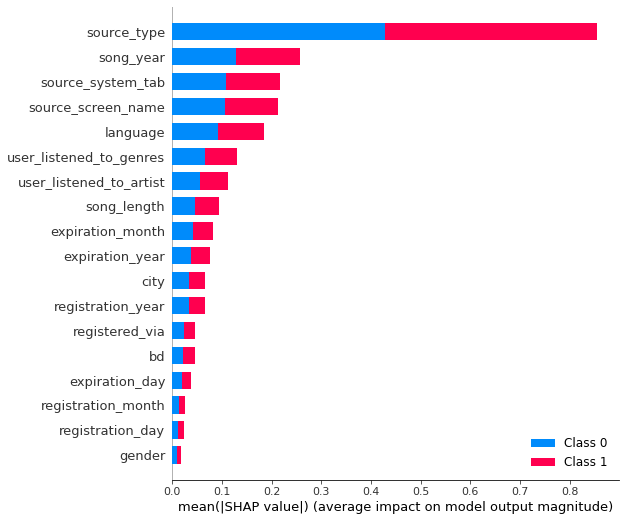

In [35]:
shap.summary_plot(shap_values, explain_df)

SHAP values' distributions.

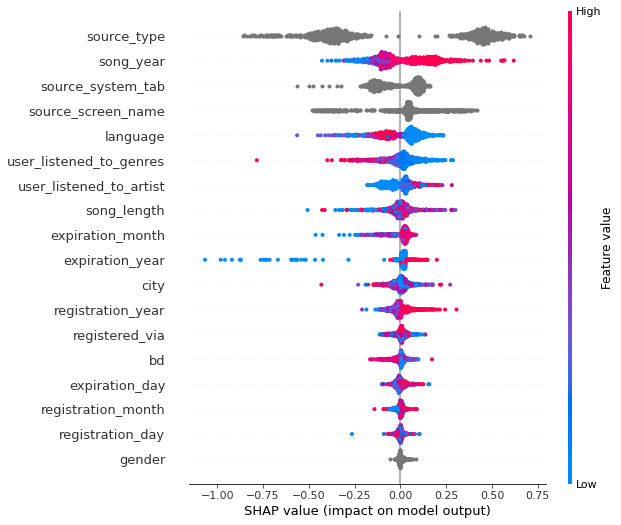

In [36]:
shap.summary_plot(shap_values[1], explain_df)

# Nonclassical embeddings: Word2Vec

In [37]:
user_embeddings = None

def rebuild_user_embeddings(wv, train_df):
  global user_embeddings
  user_ids = train_df.msno.unique().tolist()
  user_embeddings = collections.defaultdict(lambda: np.zeros(WORD2VEC_EMBEDDING_SIZE))
  user_counts = collections.defaultdict(int)
  print('Building user embeddings')
  for user_id, song_id, target in tqdm.tqdm(
      zip(train_df['msno'], train_df['song_id'], train_df['target']), file=sys.stdout):
    if target != 1.0:
      continue
    if song_id in wv:
      user_embeddings[user_id] += wv[song_id]
      user_counts[user_id] += 1
  for user_id in user_embeddings.keys():
    user_embeddings[user_id] /= user_counts[user_id]
    
def train_word2vec(train_df):
  user_ids = train_df.msno.unique().tolist()
  print('Building sessions')
  sessions = []
  for user_id in tqdm.tqdm(user_ids, file=sys.stdout):
    sessions.append(train_df[train_df['msno'] == user_id]['song_id'].tolist())

  word2vec = Word2Vec(
    window=10,
    size=WORD2VEC_EMBEDDING_SIZE,
    sg=1,  # 1 for skip-gram
    hs=0,  # 0 is when negative sampling should be used
    negative=10,
    alpha=0.03,
    min_alpha=0.0007,
    workers=multiprocessing.cpu_count(),
    seed=SEED)

  print('Building vocabulary')
  word2vec.build_vocab(sessions, progress_per=1000)

  print('Training word2vec')
  word2vec.train(sessions, total_examples=word2vec.corpus_count, epochs=WORD2VEC_EPOCHS)

  word2vec.init_sims(replace=True)
  rebuild_user_embeddings(word2vec.wv, train_df)
  return word2vec

In [38]:
word2vec = train_word2vec(train_df)

Building sessions
100%|██████████| 30755/30755 [01:21<00:00, 375.59it/s]
Building vocabulary
Training word2vec
Building user embeddings
7377418it [00:13, 536796.65it/s]


## Word2Vec similars

In [39]:
def similar_song_ids(song_id, n=10):
  song_embedding = word2vec.wv[song_id]
  similars = word2vec.wv.similar_by_vector(song_embedding, topn=n+1)[1:]
  return similars

In [40]:
artist_name = 'Dr. Dre'
song_name = 'I Need A Doctor'
songs_df_raw[songs_df_raw.artist_name == artist_name].merge(
  song_extra_info_df_raw[song_extra_info_df_raw.name == song_name],
  on='song_id',
  how='inner')

,song_id,song_length,genre_ids,artist_name,composer,lyricist,language,name,isrc
0,z8XoLXqRvdhFEyS09fu3HkhLmRNwCnH0ZY5RHNf1imU=,283654,1259,Dr. Dre,Skylar Grey| André Romell Young| Marshall Math...,NaN,52.0,I Need A Doctor,USUM71029031


In [41]:
song_id = 'z8XoLXqRvdhFEyS09fu3HkhLmRNwCnH0ZY5RHNf1imU='

In [42]:
for similar_id, similarity in similar_song_ids(song_id):
  artist_name = songs_df_raw[songs_df_raw.song_id == similar_id].artist_name.tolist()[0]
  song_name = song_extra_info_df_raw[song_extra_info_df_raw.song_id == similar_id].name.tolist()[0]
  print(f'Similarity={similarity:10.3f} aritist_name={artist_name:20} song_name={song_name:20}')

Similarity=     0.907 aritist_name=Dr. Dre              song_name=Still D.R.E.        
Similarity=     0.887 aritist_name=Eminem               song_name=Mockingbird         
Similarity=     0.878 aritist_name=Eminem               song_name=8 Mile              
Similarity=     0.877 aritist_name=Various Artists      song_name=Kings Never Die     
Similarity=     0.875 aritist_name=Macklemore & Ryan Lewis song_name=Thrift Shop (feat. Wanz)
Similarity=     0.874 aritist_name=Kanye West           song_name=Only One            
Similarity=     0.874 aritist_name=2Pac                 song_name=California Love     
Similarity=     0.872 aritist_name=Wiz Khalifa          song_name=Black And Yellow    
Similarity=     0.870 aritist_name=Macklemore & Ryan Lewis song_name=Wing$               
Similarity=     0.862 aritist_name=G-Eazy               song_name=I Mean It           


Similars look great.

## Word2Vec as a recommender system

In [43]:
def get_user_word2vec_embedding(user_id):
  global user_embeddings
  return user_embeddings[user_id]

In [44]:
sample_user_id = 'FGtllVqz18RPiwJj/edr2gV78zirAiY/9SmYvia+kCg='
sample_user_embedding = get_user_word2vec_embedding(sample_user_id)
sample_user_embedding

array([-0.11537506, -0.17373908, -0.07149412, -0.00271768, -0.07275858,
       -0.16619683,  0.05182856, -0.04667749, -0.00923983,  0.24289865,
        0.03020387, -0.06777959, -0.0900482 ,  0.12650281,  0.09444018,
        0.04468319,  0.00898134, -0.28095023,  0.0468175 ,  0.00087269,
       -0.07209961, -0.06336015,  0.13854575, -0.10212682,  0.14498772,
        0.13671389, -0.03444342, -0.0385368 ,  0.20327138,  0.04951512,
       -0.17915661,  0.06813783])

In [45]:
def word2vec_similarity(user_embedding, song_embedding):
  user_embedding_norm = np.linalg.norm(user_embedding)
  song_embedding_norm = np.linalg.norm(song_embedding)
  if user_embedding_norm < 1e-9 or song_embedding_norm < 1e-9:
    similarity = 0.0
  else:
    similarity = np.dot(user_embedding, song_embedding) / (user_embedding_norm * song_embedding_norm)
  return similarity

In [46]:
def word2vec_ranking_fn(wv, eval_df):
  similarities = []
  for user_id, song_id in tqdm.tqdm(zip(eval_df['msno'], eval_df['song_id']), file=sys.stdout):
    user_embedding = get_user_word2vec_embedding(user_id)
    song_embedding = wv[song_id] if song_id in wv else np.zeros(WORD2VEC_EMBEDDING_SIZE)
    similarity = word2vec_similarity(user_embedding, song_embedding)
    similarities.append(similarity)
  return np.array(similarities)

In [47]:
evaluation = evaluate_model_ranking_fn(
  lambda eval_df: word2vec_ranking_fn(word2vec.wv, eval_df),
  train_df)

Running the model inference
7377418it [01:46, 69492.61it/s]
Aggregating the results
7377418it [00:04, 1619775.52it/s]
Evaluating by user
100%|██████████| 30755/30755 [00:03<00:00, 9639.36it/s] 
ModelEvaluation(mapk=0.7423506899553478)


Evaluating the Word2Vec model using K-fold cross validation (the final score is the output of the cell).

In [48]:
evaluations = k_fold_cross_validation(
  train_df,
  k=CROSS_VALIDATION_K,
  train_model_fn=train_word2vec,
  preprocess_val_fn=None,
  build_ranking_fn=lambda word2vec: lambda eval_df: word2vec_ranking_fn(word2vec.wv, eval_df))
mapks = list(map(lambda evaluation: evaluation.mapk, evaluations))
np.mean(mapks)

Taking split number 0 as the validation set
Building sessions
100%|██████████| 30548/30548 [01:13<00:00, 414.93it/s]
Building vocabulary
Training word2vec
Building user embeddings
5901934it [00:11, 516510.63it/s]
Running the model inference
1475484it [00:21, 68241.60it/s]
Aggregating the results
1475484it [00:01, 1353320.36it/s]
Evaluating by user
100%|██████████| 28614/28614 [00:00<00:00, 36667.50it/s]
ModelEvaluation(mapk=0.6880452547991852)
Taking split number 1 as the validation set
Building sessions
100%|██████████| 30543/30543 [01:13<00:00, 413.09it/s]
Building vocabulary
Training word2vec
Building user embeddings
5901934it [00:11, 497755.11it/s]
Running the model inference
1475484it [00:22, 66346.37it/s]
Aggregating the results
1475484it [00:01, 1239422.95it/s]
Evaluating by user
100%|██████████| 28608/28608 [00:00<00:00, 35984.81it/s]
ModelEvaluation(mapk=0.6875360414331032)
Taking split number 2 as the validation set
Building sessions
 96%|█████████▋| 29407/30516 [01:11<00:02,

0.6881102404488727

## Word2Vec + GBDT

In [49]:
def get_user_song_similarity(wv, row):
  global user_embeddings
  user_id = row['msno']
  song_id = row['song_id']
  user_embedding = user_embeddings[user_id]
  song_embedding = wv[song_id] if song_id in wv else np.zeros(WORD2VEC_EMBEDDING_SIZE)
  return word2vec_similarity(user_embedding, song_embedding)

def extend_data_with_word2vec(word2vec, df):
  print('Extending the data with w2v_sim feature')
  wv = word2vec.wv
  df = df.copy()
  df['w2v_sim'] = word2vec_ranking_fn(wv, df)
  return df

extended_feature_columns = feature_columns + ['w2v_sim']

train_word2vec_lightgbm_cache = {}

def train_word2vec_lightgbm(train_df, params):
  train_df_hash = sum(train_df.index)
  if train_df_hash not in train_word2vec_lightgbm_cache:
    word2vec = train_word2vec(train_df)
    train_df = extend_data_with_word2vec(word2vec, train_df)
    train_word2vec_lightgbm_cache[train_df_hash] = (word2vec, train_df)
  word2vec, train_df = train_word2vec_lightgbm_cache[train_df_hash]
  model = train_lightgbm(train_df, extended_feature_columns, params)
  return word2vec, model

Tuning the lightgbm parameters (using Gaussian process as the surrogate function) to maximize evaluation metric (MAP@10 on K-fold cross validation).

In [50]:
results = tune_params_for_k_fold(
  lambda params:
    k_fold_cross_validation(
      train_df,
      k=CROSS_VALIDATION_K,
      train_model_fn=lambda train_df: train_word2vec_lightgbm(train_df, params),
      preprocess_val_fn=lambda models, df: extend_data_with_word2vec(models[0], df),
      build_ranking_fn=lambda models: lambda eval_df: lightgbm_ranking_fn(models[1], eval_df)))

Taking split number 0 as the validation set
Building sessions
100%|██████████| 30548/30548 [01:08<00:00, 444.12it/s]
Building vocabulary
Training word2vec
Building user embeddings
5901934it [00:10, 565252.57it/s]
Extending the data with w2v_sim feature
5901934it [01:25, 68714.27it/s]
Training the model with params {'num_boost_round': 48, 'early_stopping_rounds': 10, 'learning_rate': 0.3156631787042951, 'max_depth': 6, 'objective': 'binary', 'metric': 'auc', 'num_leaves': 252, 'verbosity': 0, 'boosting': 'gbdt'}
Extending the data with w2v_sim feature
1475484it [00:21, 67351.08it/s]
Running the model inference
Aggregating the results
1475484it [00:01, 1253669.86it/s]
Evaluating by user
100%|██████████| 28614/28614 [00:00<00:00, 38152.32it/s]
ModelEvaluation(mapk=0.7351592132517522)
Taking split number 1 as the validation set
Building sessions
100%|██████████| 30543/30543 [01:08<00:00, 445.38it/s]
Building vocabulary
Training word2vec
Building user embeddings
5901934it [00:11, 529572.85i

IOPub message rate exceeded.
The notebook server will temporarily stop sending output
to the client in order to avoid crashing it.
To change this limit, set the config variable
`--NotebookApp.iopub_msg_rate_limit`.

Current values:
NotebookApp.iopub_msg_rate_limit=1000.0 (msgs/sec)
NotebookApp.rate_limit_window=3.0 (secs)



1475483it [00:21, 68371.90it/s]
Running the model inference
Aggregating the results
1475483it [00:01, 1147198.71it/s]
Evaluating by user
100%|██████████| 28643/28643 [00:00<00:00, 38603.03it/s]
ModelEvaluation(mapk=0.734103429034167)
Taking split number 0 as the validation set
Training the model with params {'num_boost_round': 17, 'early_stopping_rounds': 10, 'learning_rate': 0.3265871276266289, 'max_depth': 14, 'objective': 'binary', 'metric': 'auc', 'num_leaves': 216, 'verbosity': 0, 'boosting': 'gbdt'}
Extending the data with w2v_sim feature
1475484it [00:21, 68190.36it/s]
Running the model inference
Aggregating the results
1475484it [00:01, 1121984.87it/s]
Evaluating by user
100%|██████████| 28614/28614 [00:00<00:00, 38069.63it/s]
ModelEvaluation(mapk=0.6768153596423515)
Taking split number 1 as the validation set
Training the model with params {'num_boost_round': 17, 'early_stopping_rounds': 10, 'learning_rate': 0.3265871276266289, 'max_depth': 14, 'objective': 'binary', 'metric':

Extending the data with w2v_sim feature
1475483it [00:22, 67015.41it/s]
Running the model inference
Aggregating the results
1475483it [00:01, 1136694.53it/s]
Evaluating by user
100%|██████████| 28643/28643 [00:00<00:00, 38293.66it/s]
ModelEvaluation(mapk=0.734103429034167)
Taking split number 0 as the validation set
Training the model with params {'num_boost_round': 59, 'early_stopping_rounds': 10, 'learning_rate': 0.10720724337092995, 'max_depth': 6, 'objective': 'binary', 'metric': 'auc', 'num_leaves': 166, 'verbosity': 0, 'boosting': 'gbdt'}
Extending the data with w2v_sim feature
1475484it [00:21, 67583.76it/s]
Running the model inference
Aggregating the results
1475484it [00:00, 1488458.27it/s]
Evaluating by user
100%|██████████| 28614/28614 [00:00<00:00, 37880.43it/s]
ModelEvaluation(mapk=0.6758512602983019)
Taking split number 1 as the validation set
Training the model with params {'num_boost_round': 59, 'early_stopping_rounds': 10, 'learning_rate': 0.10720724337092995, 'max_dep

Extending the data with w2v_sim feature
1475483it [00:22, 66812.12it/s]
Running the model inference
Aggregating the results
1475483it [00:01, 1143825.68it/s]
Evaluating by user
100%|██████████| 28643/28643 [00:00<00:00, 38374.99it/s]
ModelEvaluation(mapk=0.7194200259390792)
Taking split number 0 as the validation set
Training the model with params {'num_boost_round': 48, 'early_stopping_rounds': 10, 'learning_rate': 0.3081771424884598, 'max_depth': 6, 'objective': 'binary', 'metric': 'auc', 'num_leaves': 42, 'verbosity': 0, 'boosting': 'gbdt'}
Extending the data with w2v_sim feature
1475484it [00:22, 66435.30it/s]
Running the model inference
Aggregating the results
1475484it [00:01, 895925.46it/s]
Evaluating by user
100%|██████████| 28614/28614 [00:00<00:00, 37534.56it/s]
ModelEvaluation(mapk=0.6782868436468374)
Taking split number 1 as the validation set
Training the model with params {'num_boost_round': 48, 'early_stopping_rounds': 10, 'learning_rate': 0.3081771424884598, 'max_depth'

Extending the data with w2v_sim feature
1475483it [00:21, 67987.30it/s]
Running the model inference
Aggregating the results
1475483it [00:01, 1138324.95it/s]
Evaluating by user
100%|██████████| 28643/28643 [00:00<00:00, 38316.96it/s]
ModelEvaluation(mapk=0.7135467861835468)
Taking split number 0 as the validation set
Training the model with params {'num_boost_round': 48, 'early_stopping_rounds': 10, 'learning_rate': 0.290865530664544, 'max_depth': 7, 'objective': 'binary', 'metric': 'auc', 'num_leaves': 249, 'verbosity': 0, 'boosting': 'gbdt'}
Extending the data with w2v_sim feature
1475484it [00:21, 67951.99it/s]
Running the model inference
Aggregating the results
1475484it [00:01, 739248.06it/s]
Evaluating by user
100%|██████████| 28614/28614 [00:00<00:00, 37565.45it/s]
ModelEvaluation(mapk=0.6808752983627587)
Taking split number 1 as the validation set
Training the model with params {'num_boost_round': 48, 'early_stopping_rounds': 10, 'learning_rate': 0.290865530664544, 'max_depth':

Extending the data with w2v_sim feature
1475483it [00:21, 68416.93it/s]
Running the model inference
Aggregating the results
1475483it [00:01, 936385.08it/s]
Evaluating by user
100%|██████████| 28643/28643 [00:00<00:00, 38008.53it/s]
ModelEvaluation(mapk=0.7388541757076215)
Taking split number 0 as the validation set
Training the model with params {'num_boost_round': 49, 'early_stopping_rounds': 10, 'learning_rate': 0.3445479340591921, 'max_depth': 8, 'objective': 'binary', 'metric': 'auc', 'num_leaves': 242, 'verbosity': 0, 'boosting': 'gbdt'}
Extending the data with w2v_sim feature
1475484it [00:21, 67191.16it/s]
Running the model inference
Aggregating the results
1475484it [00:00, 1494749.69it/s]
Evaluating by user
100%|██████████| 28614/28614 [00:00<00:00, 37833.60it/s]
ModelEvaluation(mapk=0.6834855383379999)
Taking split number 1 as the validation set
Training the model with params {'num_boost_round': 49, 'early_stopping_rounds': 10, 'learning_rate': 0.3445479340591921, 'max_depth

Extending the data with w2v_sim feature
1475483it [00:21, 67107.76it/s]
Running the model inference
Aggregating the results
1475483it [00:02, 545895.33it/s]
Evaluating by user
100%|██████████| 28643/28643 [00:00<00:00, 37344.86it/s]
ModelEvaluation(mapk=0.7400989891408881)


In [51]:
print(f'The final score is: {-results.fun}') 
params = {search_dim.name: param for search_dim, param in zip(search_space, results.x)}
params

The final score is: 0.7355968259255952


{'num_boost_round': 48,
 'learning_rate': 0.3156631787042951,
 'max_depth': 6,
 'num_leaves': 252}

Now let's retrain the model on the whole dataset with the best parameters (from K-fold validation) for interpretation.

In [52]:
word2vec, model = train_word2vec_lightgbm(train_df, params)
extended_train_df = extend_data_with_word2vec(word2vec, train_df)
evaluation = evaluate_model_ranking_fn(
  lambda eval_df: lightgbm_ranking_fn(model, eval_df),
  extended_train_df)

Building sessions
100%|██████████| 30755/30755 [01:23<00:00, 366.18it/s]
Building vocabulary
Training word2vec
Building user embeddings
7377418it [00:13, 541193.26it/s]
Extending the data with w2v_sim feature
7377418it [01:46, 68975.81it/s]
Training the model with params {'num_boost_round': 48, 'early_stopping_rounds': 10, 'learning_rate': 0.3156631787042951, 'max_depth': 6, 'objective': 'binary', 'metric': 'auc', 'num_leaves': 252, 'verbosity': 0, 'boosting': 'gbdt'}
Extending the data with w2v_sim feature
7377418it [01:47, 68798.09it/s]
Running the model inference
Aggregating the results
7377418it [00:04, 1491659.07it/s]
Evaluating by user
100%|██████████| 30755/30755 [00:03<00:00, 9850.98it/s] 
ModelEvaluation(mapk=0.7837687174007353)


Let's look at the SHAP values for the model features.

In [53]:
np.random.seed(SEED)
explain_indexes = np.random.choice(extended_train_df.index, EXPLAIN_FROM_SAMPLES, replace=False)
explain_df = extended_train_df.iloc[explain_indexes][extended_feature_columns]

In [54]:
explainer = shap.TreeExplainer(model, feature_perturbation='tree_path_dependent')
shap_values = explainer.shap_values(explain_df)

LightGBM binary classifier with TreeExplainer shap values output has changed to a list of ndarray


SHAP values' magnitudes.

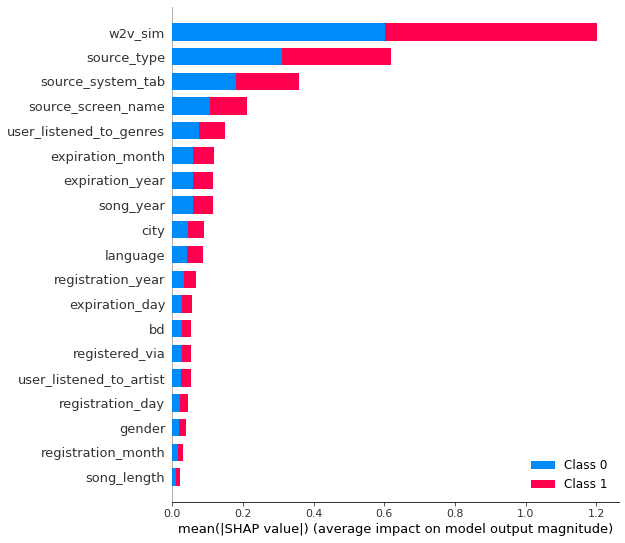

In [55]:
shap.summary_plot(shap_values, explain_df)

SHAP values' distributions.

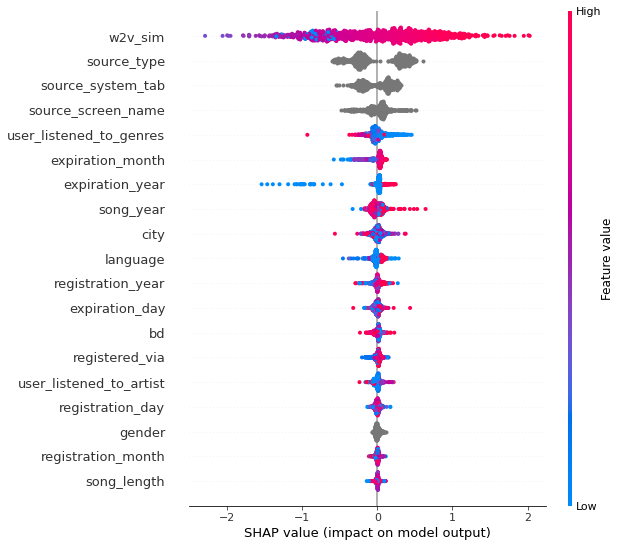

In [56]:
shap.summary_plot(shap_values[1], explain_df)

As it can be seen w2v_sim feature has a significant impact on the output of the model, and also brings a boost to the 5-fold cross validated MAP@10.

Also, the higher the value of w2v feature the more positive impact it has on the class 1 (the relevant class) which is consistent with our expectations.

In [57]:
time_ended = datetime.now()
time_spent = time_ended - time_started
print('Time spent to run the notebook:', time_spent)

Time spent to run the notebook: 3:17:16.159936


# Results (MAP@10, 5-fold cross validation)

- GBDT: 0.675146227265702
- Word2Vec as a recommender system: 0.6881102404488727
- Word2Vec + GBDT: 0.7355968259255952